Code heavily based on:
[Towards_data_science](https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/jonas/opt/miniconda3/envs/DLSC/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():  
  dev = "cuda" 
else:  
  dev = "cpu" 
print(dev)

cpu


In [3]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.0):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(dev)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(dev)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out
        # lstm_out, self.hidden_cell = lstm(x, self.hidden_cell)
        # pred = self.fc(lstm_out.view(len(x), -1))
        # return pred[-1]

def init_xavier(model, retrain_seed):
  torch.manual_seed(retrain_seed)
    
  for name, param in model.named_parameters():
    if 'bias' in name:
      nn.init.constant_(param, 0.0)
    elif 'weight' in name:
      nn.init.xavier_normal_(param)



In [4]:
training_set = pd.read_csv('Data/TrainingData_Task3.txt')
training_set_1 = training_set.iloc[:,[1]].values
training_set_2 = training_set.iloc[:,[2]].values
testing_set = pd.read_csv('Data/TestingData_Task3.txt')
testing_set
testing_set = testing_set.iloc[:,[0]].values

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length):]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set_1)
print(f"Training data: {training_data.shape}")

seq_length = 40
x, y = sliding_windows(training_data, seq_length)
print(f"x shape = {x.shape}, y shape: {y.shape}")

train_size = len(y) - 1
test_size = 1

dataX = Variable(torch.Tensor(np.array(x))).to(dev)
dataY = Variable(torch.Tensor(np.array(y))).to(dev)

trainX = Variable(torch.Tensor(np.array(x[0:train_size]))).to(dev)
trainY = Variable(torch.Tensor(np.array(y[0:train_size]))).to(dev)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)]))).to(dev)
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]))).to(dev)

Training data: (210, 1)
x shape = (169, 40, 1), y shape: (169, 1)


In [6]:
def run_sim(training_set, s_length):
  sc = MinMaxScaler()
  training_data = sc.fit_transform(training_set)
  # print(f"Training data: {training_data.shape}")

  seq_length = s_length
  x, y = sliding_windows(training_data, seq_length)
  # print(f"x shape = {x.shape}, y shape: {y.shape}")
  #train_size = int(len(y) * 0.67)
  #test_size = len(y) - train_size

  train_size = len(y) - 1
  test_size = 1

  dataX = Variable(torch.Tensor(np.array(x))).to(dev)
  dataY = Variable(torch.Tensor(np.array(y))).to(dev)

  trainX = Variable(torch.Tensor(np.array(x[0:train_size]))).to(dev)
  trainY = Variable(torch.Tensor(np.array(y[0:train_size]))).to(dev)

  testX = Variable(torch.Tensor(np.array(x[train_size:len(x)]))).to(dev)
  testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]))).to(dev)

    # [26 43 36  9 12 42 49 16 47  1 30  5 38 44 37 35 33  7  0  8 41 14 24 19
  # 31 40 21  4 18 29 23 17 48 22 20 13 10 15 32 27  3 11 34 46 28 45  2 39
  #  6 25] hidden_size 250 epochs 5000 min(MSE) = 0.329
  # for training_set_1 use retrain = 26
  # use seed 49, 250 hidden_layer
  num_epochs = 5000
  learning_rate = 0.01
  retrain = 26
  dropout = 0.3

  input_size = 1
  hidden_size = 250
  num_layers = 1

  num_classes = 1

  errors = list()

    
  learning_rate = 0.01

  lstm = LSTM(num_classes, input_size, hidden_size, num_layers, dropout).to(dev)

  init_xavier(lstm, retrain)

  criterion = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      outputs = lstm(trainX)
      optimizer.zero_grad()
      
      # obtain the loss function
      loss = criterion(outputs, trainY)
      
      loss.backward()
      
      optimizer.step()

      if (epoch + 1) % 2000 == 0:
        learning_rate /= 10
        #print(f"Learning Rate Decreased: lr = {learning_rate}")
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
      if epoch % 1000 == 0:
        pass
        # print("Epoch: %d, loss: %f" % (epoch, loss.item()))


  lstm.eval()
  with torch.no_grad():
    train_predict = lstm(dataX)

  data_predict = train_predict.data.to('cpu').numpy()
  dataY_plot = dataY.data.to('cpu').numpy()

  data_predict = sc.inverse_transform(data_predict)
  dataY_plot = sc.inverse_transform(dataY_plot)
  mse = mean_squared_error(dataY_plot, data_predict)
  errors.append(mse)

  predict = np.zeros(len(testing_set))

  current_batch = torch.from_numpy(training_data[-seq_length:,:].reshape(1, seq_length, 1)).float().to(dev)
  count = 0
  for i in range(len(testing_set)):
    lstm.eval()
    with torch.no_grad():
      new_data = lstm(current_batch)
    predict[count] = sc.inverse_transform(new_data.data.to('cpu').numpy())
    count += 1
    current_batch = torch.cat((current_batch[:, 1:, :], new_data.reshape(1, 1, 1)), dim=1)

  print(predict)

  full_predictions =  np.append(data_predict, predict)
  print(full_predictions.shape)
  plt.figure(figsize=(20, 12))
  plt.title(f'Seq length = {s_length}')
  plt.scatter(np.linspace(seq_length, seq_length + len(full_predictions), len(full_predictions)), full_predictions, marker='.', color='orange')
  plt.scatter(np.linspace(0, 210, 210), training_set, marker='.')
  plt.show()

/Users/jonas/opt/miniconda3/envs/DLSC/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[874.80877686 872.08831787 872.65844727 872.82177734 873.02642822
 873.02880859 873.03057861 873.10992432 873.13726807 873.21179199
 873.10406494 873.00195312 872.91003418 872.82141113 872.77984619
 872.8059082  872.81781006 872.45214844 870.7789917  865.93011475
 856.52703857 842.3269043  822.84875488 798.2199707  768.06634521
 739.97381592 735.13146973 737.5625     735.19012451 734.03814697
 733.84259033 733.97613525 734.18463135 729.0526123 ]
(206,)


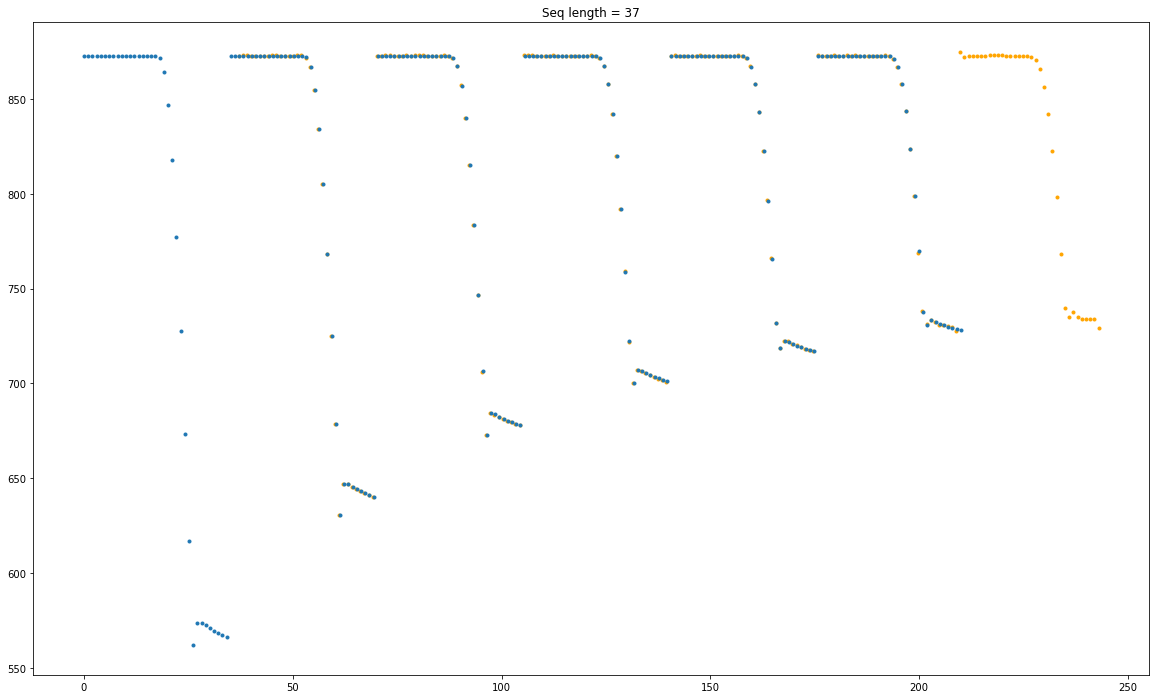

/Users/jonas/opt/miniconda3/envs/DLSC/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[803.99920654 847.09954834 862.42651367 868.94012451 871.35302734
 872.18414307 872.84301758 873.27813721 873.36816406 873.11859131
 872.77355957 872.54833984 872.48278809 872.48937988 872.47723389
 872.38781738 872.17425537 871.71447754 870.61962891 868.10070801
 862.48065186 851.58764648 836.02294922 816.22674561 792.07995605
 763.43408203 744.99316406 741.83374023 739.46026611 737.53936768
 735.97088623 734.71942139 734.78607178 726.45916748]
(206,)


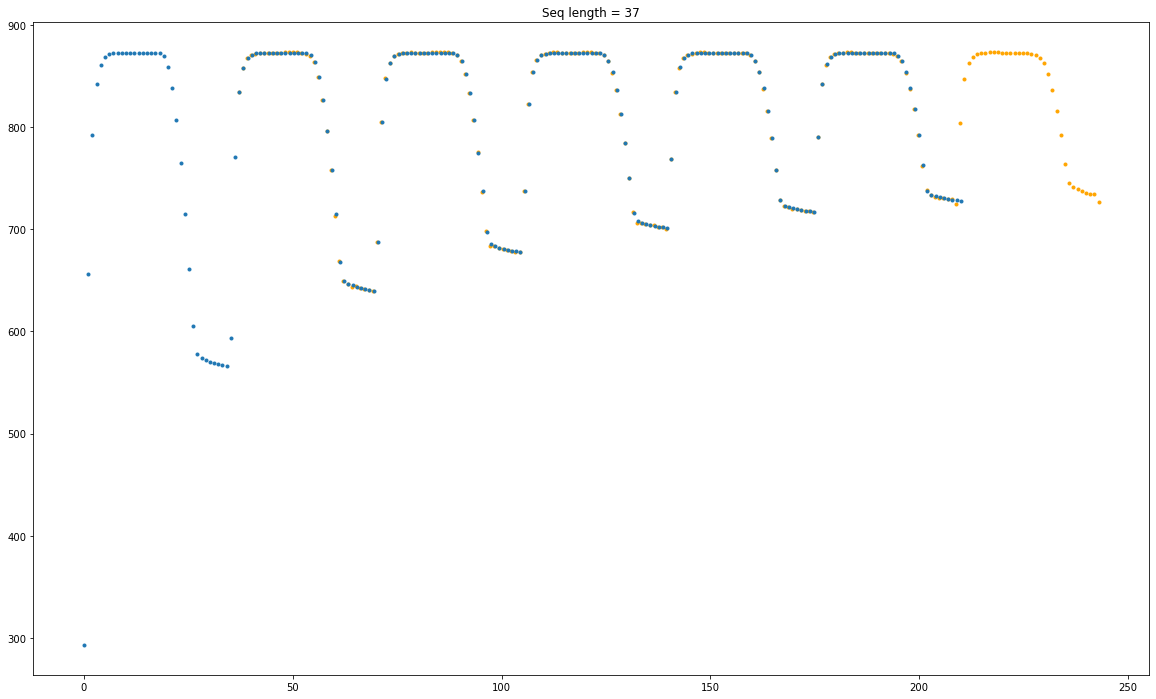

In [7]:
run_sim(training_set_1, 37)
run_sim(training_set_2, 37)